# 2-Cell and 3-Cell Motifs in PyC Subgraph (Th=100)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.proximity import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *

### 1. Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_soma = pd.read_csv('data/soma.csv')

In [3]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [4]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

In [5]:
g_th100 = get_thresholded_graph(g_actual, axls, 100)
print(nx.info(g_th100))

Name: 
Type: DiGraph
Number of nodes: 111
Number of edges: 659
Average in degree:   5.9369
Average out degree:   5.9369


### 2. Compare 2-Cell Motif Statistics (OBS vs ER vs CFG)

In [6]:
%%time
# count 2-cell motifs in the observation
obs_two_counts = count_two_neuron_motifs_graph(g_th100)
# analytically compute 2-cell motif counts in Erdos-Renyi model
er_two_counts = compute_ER_two_neuron_motifs(g_th100)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.73 ms


In [7]:
%%time
# sample graphs from CFG model and compute 2-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_two_counts = sample_motifs_parallel_continuous(continuous_sample_two_neuron_motifs, g_th100, samples=s, niters=int(1e4), threads=10)

CPU times: user 64 ms, sys: 48 ms, total: 112 ms
Wall time: 36.9 s


In [8]:
# save sampled motif counts from CFG model as intermediate data
config_two_counts.to_csv("saved/th100_2motif_cfg1000.csv", index=False)

In [7]:
# load precomputed sampled motif counts from CFG model
config_two_counts = pd.read_csv("saved/th100_2motif_cfg1000.csv")

connect probability =  0.05397215397215397


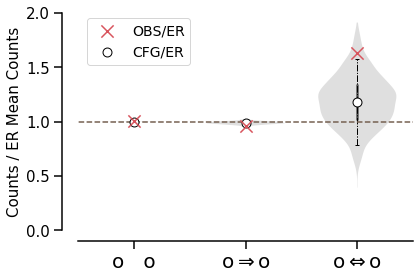

In [8]:
# relative counts in ratio (/ER expected counts)
res_two = plot_two_neuron_counts_violin(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 2), fname="th100/th100_2_violin");

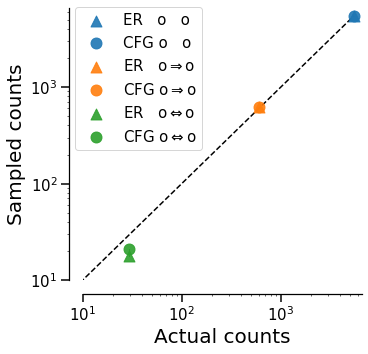

In [9]:
plot_two_neuron_counts_scatter(obs_two_counts, er_two_counts, config_two_counts, figsize=(5,5), fname="th100/th100_2_scatter")

In [10]:
res_two

,obs,er_exp,config_exp,config_std,proximity_z
actual_edges,NaN,NaN,659.000,0.000000,NaN
autapses,NaN,NaN,0.000,0.000000,NaN
bi,29.0,17.783825,21.172,4.258938,1.838017
neurons,NaN,NaN,111.000,0.000000,NaN
null,5475.0,5463.783825,5467.172,4.258938,1.838017
potential_edges,NaN,NaN,12210.000,0.000000,NaN
uni,601.0,623.432351,616.656,8.517876,-1.838017


In [11]:
# single side p-values
np.minimum((config_two_counts >= obs_two_counts).sum(0) / 1000, 
           (config_two_counts <= obs_two_counts).sum(0) / 1000)

neurons            1.000
autapses           1.000
actual_edges       1.000
uni                0.043
bi                 0.043
potential_edges    1.000
null               0.043
dtype: float64

### 2. Compare 3-Cell Motif Statistics (OBS vs ER vs CFG)

In [12]:
%%time
# count 3-cell motifs in the observation
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(g_th100), motifs)
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr, two_pr = compute_three_neuron_motif_probabilities(g_th100)
er_three_counts = compute_expected_three_neuron_motifs(g_th100, three_pr)

CPU times: user 15 s, sys: 48 ms, total: 15.1 s
Wall time: 15 s


In [25]:
%%time
# sample graphs from CFG model and compute 3-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs, g_th100, samples=s, niters=int(1e4), threads=10)

CPU times: user 76 ms, sys: 72 ms, total: 148 ms
Wall time: 45min 32s


In [26]:
# save sampled motif counts from CFG model as intermediate data
config_three_counts.to_csv("saved/th100_3motif_cfg1000.csv", index=False)

In [13]:
# load precomputed sampled motif counts from CFG model
config_three_counts = pd.read_csv("saved/th100_3motif_cfg1000.csv")
config_three_counts.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

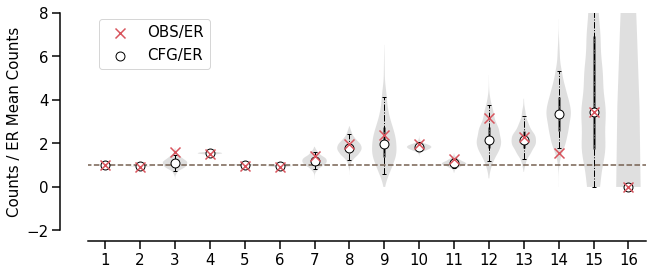

In [14]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                            subtitle='', ylim=[-2, 8], fname="th100/th100_3_violin", figsize=(10,4))

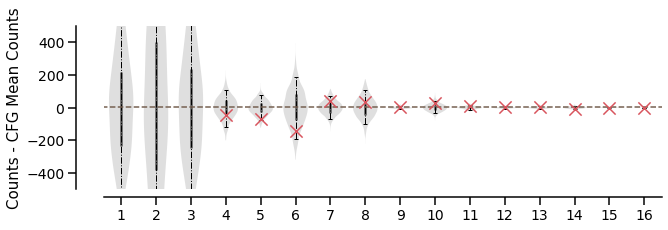

In [15]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                     subtitle='', ylim=[-500, 500], fname="th100/th100_3_violin_diff");

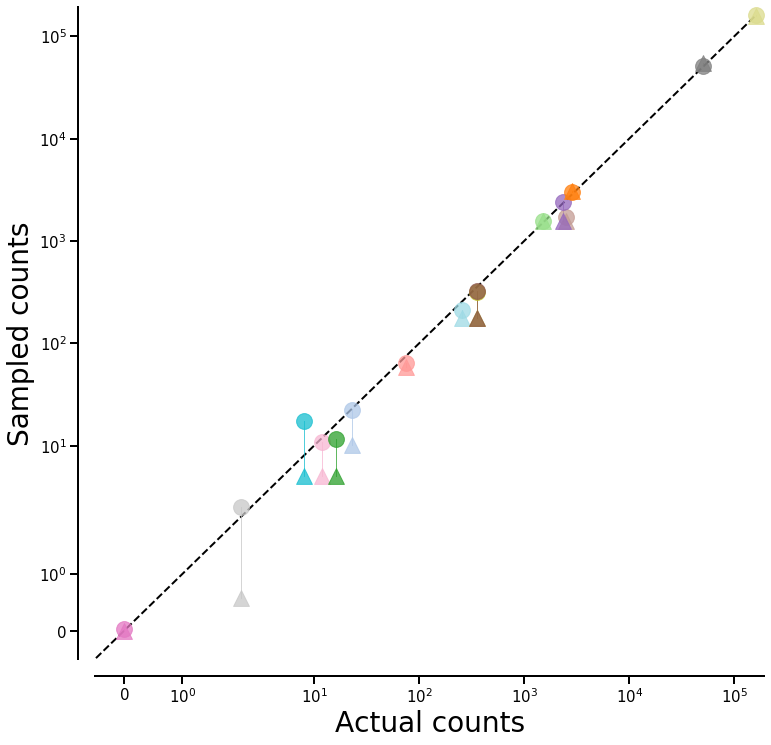

In [16]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts, config_three_counts, figsize=(12,12), fname="th100/th100_3_scatter")

In [17]:
res_three

,obs,er_exp,config_exp,config_std,config_z
1,161442,159006.336277,160704.342,340.897480,2.163870
2,50074,54429.144978,51444.487,585.244266,-2.341735
3,2478,1552.627761,1697.439,351.785465,2.218855
4,2362,1552.627761,2407.572,66.731461,-0.682916
5,1509,1552.627761,1577.979,44.156612,-1.562144
6,2854,3105.255523,2996.292,111.406023,-1.277238
7,255,177.158981,212.228,42.015394,1.018008
8,353,177.158981,319.897,63.171251,0.524020
9,12,5.053578,10.902,5.482194,0.200285
10,352,177.158981,325.826,23.645694,1.106925


In [18]:
# one side p-values
np.minimum((config_three_counts >= obs_three_counts).sum(0) / 1000, 
           (config_three_counts <= obs_three_counts).sum(0) / 1000)

1     0.021
2     0.014
3     0.017
4     0.242
5     0.059
6     0.101
7     0.160
8     0.301
9     0.405
10    0.131
11    0.123
12    0.173
13    0.455
14    0.040
15    0.564
16    0.968
dtype: float64

### 3. Compare 3-Cell Motif Statistics (OBS vs gER vs gCFG)

In [19]:
%%time
# analytically compute 2-cell motif counts in generalized Erdos-Renyi model
three_pr_GE, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th100)
er_three_counts_GE = compute_expected_three_neuron_motifs(g_th100, three_pr_GE)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.97 ms


In [91]:
%%time
# sample graphs from generalized CFG (gCFG) model and compute 3-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts_GE = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs_GE, g_th100, samples=s, niters=int(1e4), threads=10)

CPU times: user 108 ms, sys: 96 ms, total: 204 ms
Wall time: 45min 23s


In [92]:
# save sampled motif counts from gCFG model as intermediate data
config_three_counts_GE.to_csv("saved/th100_3motif_gcfg1000.csv", index=False)

In [20]:
# load precomputed sampled motif counts from gCFG model
config_three_counts_GE = pd.read_csv("saved/th100_3motif_gcfg1000.csv")
config_three_counts_GE.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

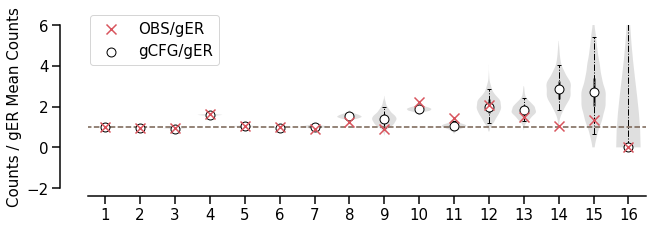

In [21]:
# relative counts in ratio (/ER expected counts)
res_three_GE = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                            subtitle='', ylim=[-2, 6], cfg_name="gCFG", er_name="gER",
                                            fname="th100/th100_3_violin_GE", figsize=(10,3))

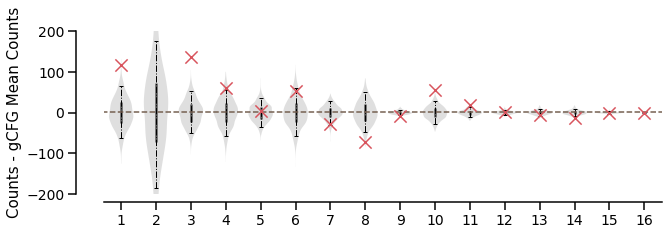

In [22]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts_GE, config_three_counts_GE, cfg_name="gCFG", 
                                     subtitle='', ylim=[-200, 200], fname="th100/th100_3_violin_diff_GE");

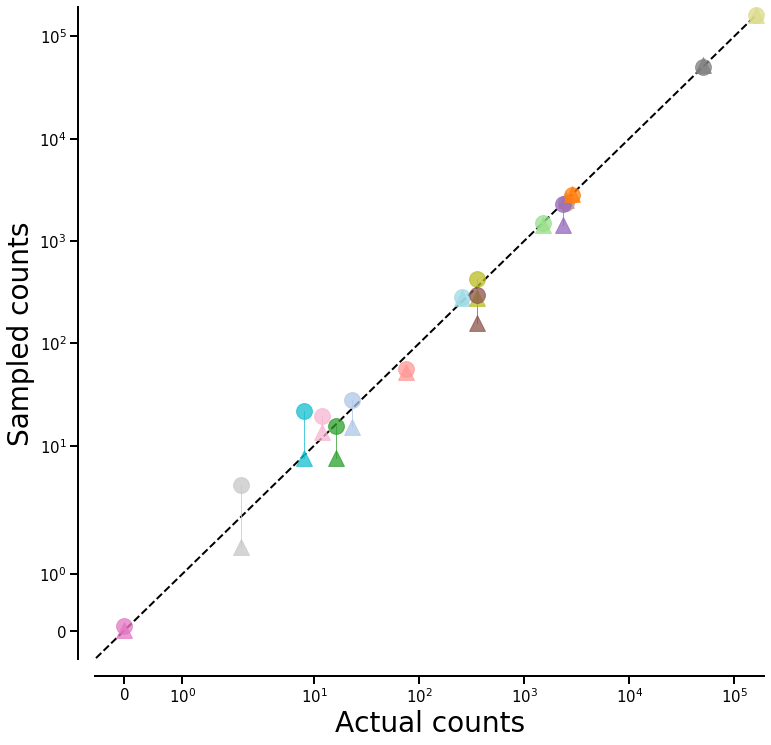

In [23]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                 figsize=(12,12), fname="th100/th100_3_scatter_GE")

In [24]:
res_three_GE

,obs,er_exp,config_exp,config_std,config_z
1,161442,159987.582931,161325.464,38.394568,3.035221
2,50074,52686.321831,50390.810,106.528833,-2.973937
3,2478,2542.268441,2341.428,31.492294,4.336680
4,2362,1445.866640,2300.953,34.330298,1.778225
5,1509,1445.866640,1506.067,21.809451,0.134483
6,2854,2891.733280,2800.980,34.979182,1.515759
7,255,279.069102,282.632,17.346627,-1.592932
8,353,279.069102,424.108,29.044826,-2.448216
9,12,13.465897,19.392,4.416768,-1.673622
10,352,158.715224,297.456,16.819303,3.242941


In [25]:
# p-values
np.minimum((config_three_counts_GE >= obs_three_counts).sum(0) / 1000, 
           (config_three_counts_GE <= obs_three_counts).sum(0) / 1000)

1     0.003
2     0.002
3     0.000
4     0.043
5     0.446
6     0.074
7     0.066
8     0.004
9     0.041
10    0.002
11    0.006
12    0.476
13    0.194
14    0.002
15    0.222
16    0.918
dtype: float64

### 4. Compare 3-Cell Motif Statistics (OBS vs gER vs CFG)

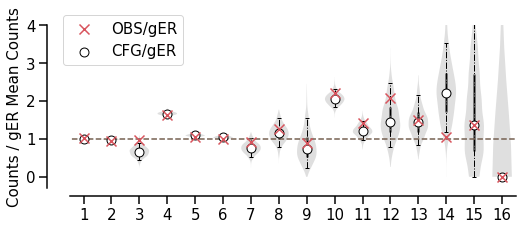

In [26]:
# relative counts in ratio (/ER expected counts)
res_three_CGE = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                            subtitle='', ylim=[-0.3, 4], er_name="gER", fname="th100/th100_3_violin_CGE", figsize=(8,3))

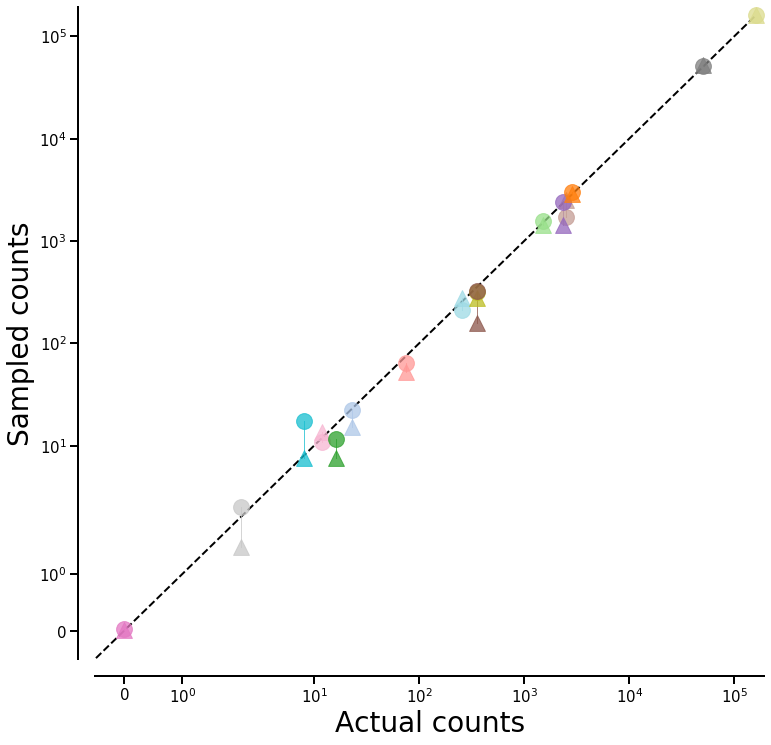

In [27]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                 figsize=(12,12), fname="th100/th100_3_scatter_CGE")

### 5. Compare 3-Cell Motif Statistics (OBS vs gER vs ER)

In [38]:
%%time
# sample graphs from generalized ER (gER) model and compute 3-cell motif stats for each sample
s=100
er_three_counts_GE_SAMPLED = sample_motifs_parallel_continuous_GE_ER(
    sample_three_neuron_motifs_GE_ER, 
    g_th100, samples=s, threads=10)

CPU times: user 84 ms, sys: 104 ms, total: 188 ms
Wall time: 1h 1min 39s


In [39]:
# save sampled motif counts from gER model as intermediate data
er_three_counts_GE_SAMPLED.to_csv("saved/th100_3motif_ger1000.csv", index=False)

In [41]:
# load precomputed sampled motif counts from gER model
er_three_counts_GE_SAMPLED = pd.read_csv("saved/th100_3motif_ger1000.csv")
er_three_counts_GE_SAMPLED.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

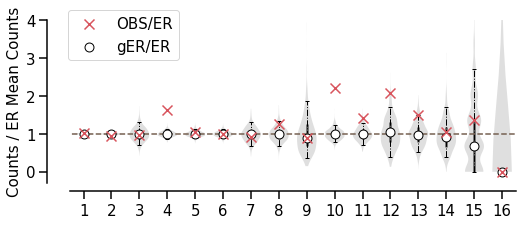

In [47]:
res_three_CGE = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, er_three_counts_GE_SAMPLED, 
                                            subtitle='', ylim=[-0.3, 4], er_name="ER", cfg_name="gER", fname="th100/th100_3_violin_GEER", figsize=(8,3))

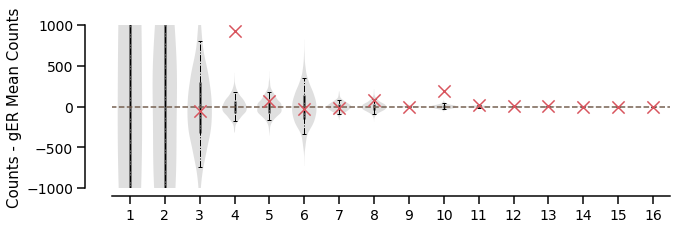

In [49]:
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts_GE, er_three_counts_GE_SAMPLED, 
                                     subtitle='', ylim=[-1000, 1000], er_name="ER", cfg_name="gER", fname="th100/th100_3_violin_diff_GEER");

In [124]:
res_three_CGE

,obs,er_exp,config_exp,config_std,config_z
1,171860,170307.800414,170322.599,2132.481692,0.720945
2,51793,54584.682473,54550.607,1639.575274,-1.681903
3,2531,2603.545710,2627.872,493.123072,-0.196446
4,2436,1457.893470,1454.848,112.715428,8.704682
5,1521,1457.893470,1455.834,113.183351,0.575756
6,2891,2915.786939,2910.747,214.983127,-0.091854
7,255,278.150728,280.837,55.721192,-0.463684
8,358,278.150728,280.417,55.403743,1.400321
9,12,13.267058,13.542,6.280898,-0.245506
10,355,155.754565,155.491,21.017365,9.492579


In [48]:
# p-values
np.minimum((er_three_counts_GE_SAMPLED >= obs_three_counts).sum(0) / 1000, 
           (er_three_counts_GE_SAMPLED <= obs_three_counts).sum(0) / 1000)

1     0.261
2     0.048
3     0.481
4     0.000
5     0.254
6     0.470
7     0.362
8     0.085
9     0.504
10    0.000
11    0.011
12    0.010
13    0.066
14    0.452
15    0.409
16    0.981
dtype: float64

### 6. More Scatter Plots for Model Comparison (gER vs ER / gCFG vs CFG / gCFG vs gER)

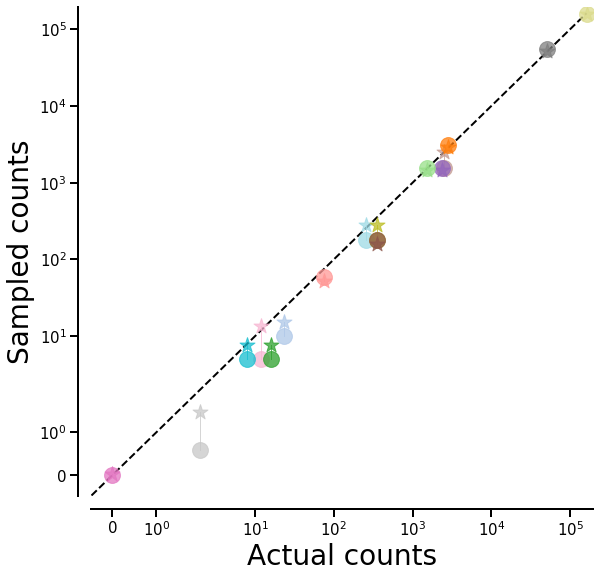

In [31]:
plot_three_neuron_counts_scatter_adapt(obs_three_counts, er_three_counts, er_three_counts_GE, 
                                 figsize=(9,9), fname="th100/th100_3_scatter_E-GE")

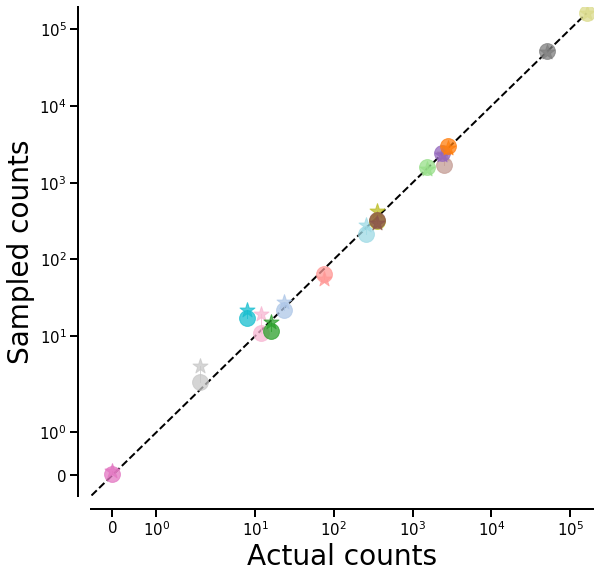

In [32]:
plot_three_neuron_counts_scatter_adapt(obs_three_counts, config_three_counts.mean(0), config_three_counts_GE.mean(0), 
                                 figsize=(9,9), fname="th100/th100_3_scatter_C-GC")

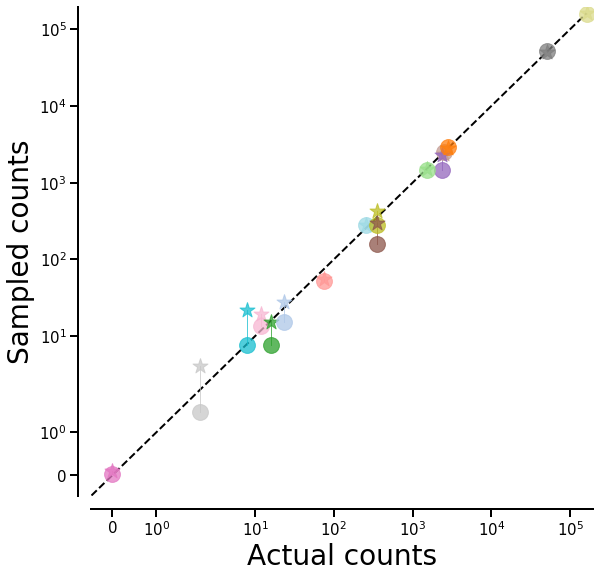

In [33]:
plot_three_neuron_counts_scatter_adapt(obs_three_counts, er_three_counts_GE, config_three_counts_GE.mean(0), 
                                 figsize=(9,9), fname="th100/th100_3_scatter_GC-GE")

### 7. Clustering Coefficient

In [28]:
# clustering coefficient of the observed network
nx.transitivity(g_th100.to_undirected())

0.16127946127946127

In [29]:
# expected clustering coefficient of the networsk sampled from the ER model
1-two_pr['pr_null']

0.10247731571679497

In [30]:
# expected clustering coefficient of the networsk sampled from the CFG model
clustering_coef(config_three_counts).mean()

0.14957100383560884

In [31]:
# expected clustering coefficient of the networsk sampled from the generalized ER model
1-two_pr_GE['pr_null']

0.10066371681415931

In [32]:
# expected clustering coefficient of the networsk sampled from the generalized CFG model
clustering_coef(config_three_counts_GE).mean()

0.14626042082816113

In [34]:
# p-value: CFG vs OBS
(clustering_coef(config_three_counts) >= nx.transitivity(g_th100.to_undirected())).sum()/1000

0.03